# Low-Rank plus noise Teacher-Student learning

In [1]:

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats



In [2]:
def style_axes(ax, numyticks=5, numxticks=5, xlabel=False, ylabel=False, xlim=None, ylim=None):
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=24)
    ax.yaxis.set_major_locator(plt.MaxNLocator(numyticks))
    
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=20)
    ax.xaxis.set_major_locator(plt.MaxNLocator(numxticks))

    ax.xaxis.offsetText.set_fontsize(20)
    ax.yaxis.offsetText.set_fontsize(20)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=20)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=20)
    
    # Limits
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)

In [3]:
def generate(n, m, sigma):
    Ux=scipy.stats.ortho_group.rvs(n)
    Vx=scipy.stats.ortho_group.rvs(m)
    Sx = np.zeros((n,m))
    for i, val in enumerate(sigma):
        Sx[i,i] = val
    return Ux,Vx,Ux@Sx@Vx

In [4]:
# V: n x n
# U: n x m

def forward(U, V, x):
    
    return x @ V[0]@np.diag(V[1]) @ np.diag(U[1]) @ U[0]

def loss(U, V, x, y):
    yhat = forward(U, V, x)
    return 0.5 * np.sum(np.square(yhat - y))

def loss_test(U, V, W):
    return np.mean(np.square(V[0]@np.diag(V[1]) @ np.diag(U[1]) @ U[0]-W))

def gradient(U, V, sx, sigma=0):
    su,sv=U[1],V[1]
    noise = np.random.normal(scale=sigma, size=len(su))
    residual = (sv*su-sx+noise)
    gV = residual*su
    gU = residual*sv
    return gV,gU

In [5]:
#Data generation
np.random.seed(0) #reproducibility
N, n, m, d = 1024,64,64,8
_, _, W = generate(n, m, np.linspace(0.5, 1, d))
_, _, X = generate(N, n, np.ones(n))
sigma=0.5
y = X @ W + sigma * np.random.randn(N,m)/np.sqrt(m)
y_true = X @ W
Vx,Sx,Ux=np.linalg.svd(X.T@y)

In [6]:
import pickle
data_dict={'Ltrain': [],'Ltest': [], 'Us_list_list': [],'Vs_list_list': []}
for i in tqdm(range(256)):
    with open(f'../exps/Teacher_student_setup_SGD_diagonal_f_{i}.pickle', 'rb') as handle:
        a=pickle.load(handle)
        for key in data_dict.keys():
            data_dict[key].append(a[key])
for key in data_dict.keys():
    data_dict[key]=np.array(data_dict[key])
    

100%|██████████| 256/256 [01:02<00:00,  4.07it/s]


In [7]:
Ltrain=data_dict['Ltrain'].mean(axis=0)
Ltest=data_dict['Ltest'].mean(axis=0)
n_sigma_list=[0,5,10,15,20]
Sx_list=(data_dict['Vs_list_list']*data_dict['Us_list_list']).mean(axis=0)
Sx_var_list=np.abs(data_dict['Vs_list_list']*data_dict['Us_list_list']).std(axis=0)/np.sqrt(256)

In [9]:
def E_s(s,eta,sigma,t,s0):
    lb2=(s-1/2*eta*sigma*sigma)/(1+(-1+(s-1/2*eta*sigma*sigma)/s0)*np.exp(-(2*s-1*eta*sigma*sigma)*t))
    ub=s/(1+(-1+s/s0)*np.exp(-2*s*t))
    return lb2,ub

/var/tmp/ipykernel_5198/1482430564.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('winter', len(n_sigma_list))
/var/tmp/ipykernel_5198/1482430564.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('winter', len(n_sigma_list))
/var/tmp/ipykernel_5198/1482430564.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('copper', len(Sx_list[-1][-1000::100,:]))


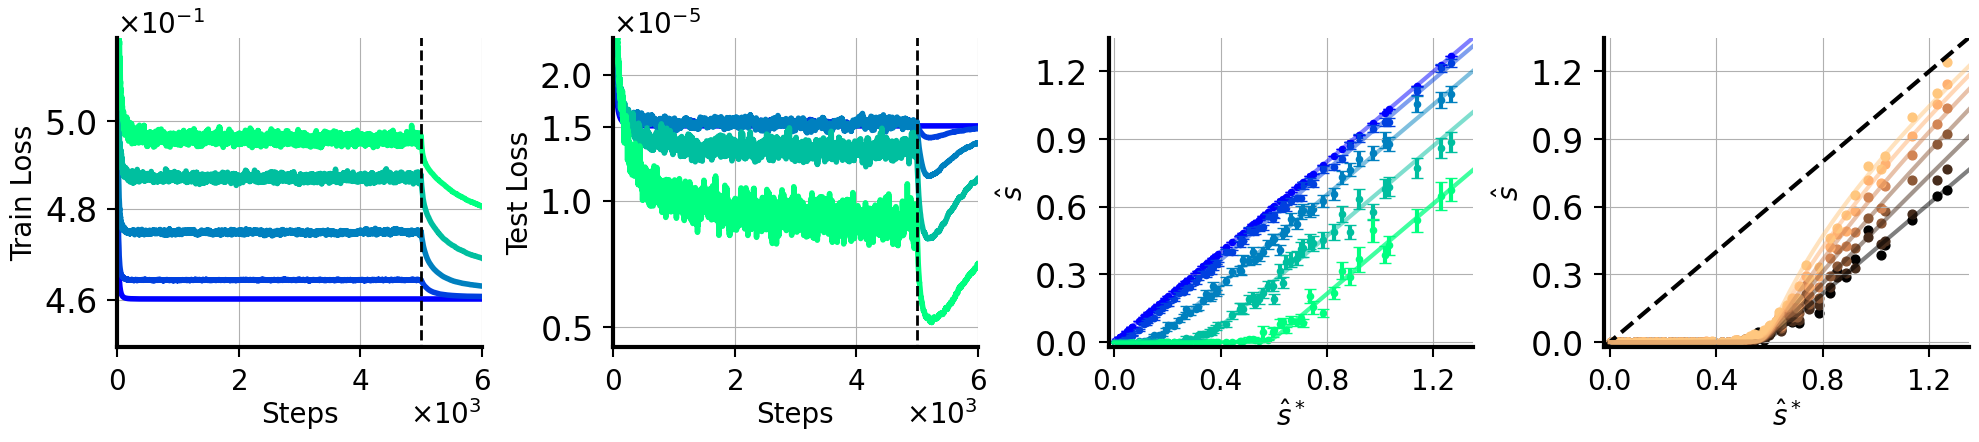

In [37]:
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

nrows, ncols = 1, 4
fig, ax = plt.subplots(nrows, ncols, figsize=(5.0* ncols, 4.5 * nrows))

cmap = matplotlib.cm.get_cmap('winter', len(n_sigma_list))
    
for i, (name, L) in enumerate(zip(["Train Loss", "Test Loss"], [Ltrain, Ltest])):
       
    # Make Legend
    c = np.arange(1, len(n_sigma_list) + 1)
    dummie_cax = ax[i].scatter(c, c, c=n_sigma_list, cmap=cmap)
    ax[i].cla() # Clear axis
    
    # Plot Loss
    for j, Lj in enumerate(L):
        if j==len(n_sigma_list)-1:
            ax[i].plot(np.arange(0,6001), Lj[0:]/y.var().item()/N/m, lw=4, c=cmap(j),label='Full Batch')
        else:
            ax[i].plot(np.arange(0,6001), Lj[0:]/y.var().item()/N/m, lw=4, c=cmap(j),label='%d'%n_sigma_list[j])
    
    tempt=ax[i].get_ylim()
    style_axes(ax[i], xlabel="Steps", ylabel=name, numxticks=4)
    ax[i].vlines(5000,0,1000,color='k',linestyle='--',lw=2)
    ax[i].set_yscale('log')
    ax[i].set_yticks([],minor=True)
    ax[i].set_yticks([],minor=False)
    ax[i].set_yticklabels([])
    ax[i].set_xlim(0,6001)
    ax[i].set_ylim(*tempt)
    ax[i].get_xaxis().set_major_formatter(ScalarFormatter(useMathText=True))
    ax[i].get_yaxis().set_major_formatter(ScalarFormatter(useMathText=True))
    ax[i].ticklabel_format(style='sci',scilimits=(0,0),axis='both')
    ax[i].grid()

ax[0].set_ylim([0.45,0.52])
ax[0].set_yticks([0.46,0.48,0.50])
ax[1].set_yticks([0.5e-5,1.0e-5,1.5e-5,2.0e-5])
ax[1].set_ylim(0.45e-5,2.45e-5)
fig.tight_layout()

cmap = matplotlib.cm.get_cmap('winter', len(n_sigma_list))
# Make Legend
c = np.arange(1, len(n_sigma_list))
dummie_cax = ax[2].scatter(c, c, c=c, cmap=cmap)
ax[2].cla() # Clear axis
style_axes(ax[2], xlabel=r"$\hat{s}^*$", ylabel=r'$\hat{s}$', numxticks=4)
for i,sigma in enumerate(n_sigma_list):
    ax[2].errorbar(Sx,np.abs(Sx_list[i,5000,:]),Sx_var_list[i,5000,:],capsize=4,ls='none',color=cmap(i),lw=3,label='$\sigma=$%d'%sigma)
    ax[2].scatter(Sx,np.abs(Sx_list[i,5000,:]),color=cmap(i),s=20)
    ax[2].plot(np.linspace(0.0001,1.5,1001),E_s(np.linspace(0.0001,1.5,1001),3/1024,sigma,50000*1/1024,1)[0],color=cmap(i),alpha=.5,lw=3)
ax[2].plot(np.linspace(0.0001,1.5,1001),E_s(np.linspace(0.0001,1.5,1001),3/1024,sigma,50000*1/1024,1)[0],color=cmap(i),lw=3,label='Theory',alpha=.5)
ax[2].set_xlim(-0.02,1.35)
ax[2].set_ylim(-0.02,1.35)
ax[2].grid()

cmap = matplotlib.cm.get_cmap('copper', len(Sx_list[-1][-1000::100,:]))
style_axes(ax[3], xlabel=r"$\hat{s}^*$", ylabel=r'$\hat{s}$', numxticks=4)
for i,s in enumerate(Sx_list[-1][-1001::200,:]):
    im=ax[3].scatter(Sx,s,color=cmap(2*i),s=40)
ax[3].plot([-0.02,1.35],[-0.02,1.35],'k--',lw=3)
ax[3].set_xlim(-0.02,1.35)
ax[3].set_ylim(-0.02,1.35)
ax[3].grid()

s0=E_s(np.linspace(0.0001,1.5,1001),3/1024,20,50000*1/1024,1)[0]
for i in range(11)[::2]:
    ax[3].plot(np.linspace(0.0001,1.5,1001),E_s(np.linspace(0.0001,1.5,1001),0.3/1024,20,1000*i*0.1/1024,s0)[0],color=cmap(i),lw=3, alpha=.5)

plt.savefig('fig3.pdf',bbox_inches='tight')